In [8]:
#@title 
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2021/trabajo-final/

# Trabajo Final: Ejercicio 1

Este ejercicio consiste en trabajar sobre la primera parte del curso para extraer un modelo geométrico de una imagen.

Para este ejercicio vamos a trabajar sobre una imagen de una cancha de Fútbol.

Se probeen las funciones `draw_lines` y `draw_lines_polar` que les pueden servir para dibujar las rectas encontradas. 

\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de interenet le agreguen el link en comentarios de donde fue sacado ese código.*

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_utils import draw_lines, draw_lines_polar
import random

In [3]:
input_image = 'images/football.png'

### Load Input Image ###

In [4]:
image = cv2.imread(input_image,cv2.IMREAD_GRAYSCALE)/255

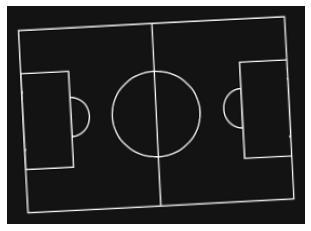

In [5]:
plt.imshow(image,cmap='gray')
plt.axis('off')
plt.show()

In [6]:
image_bgr = cv2.imread(input_image,cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

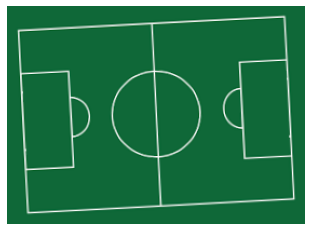

In [7]:
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

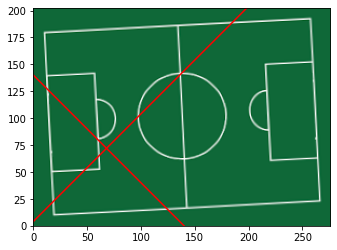

In [7]:
draw_lines(image_rgb,[[1,4],[-1,140]])

drawing rho 20 theta 120
drawing rho 100 theta 90


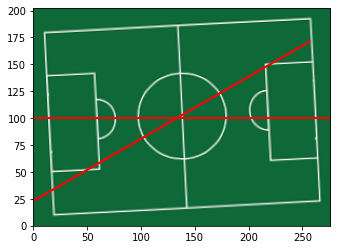

In [8]:
draw_lines_polar(image_rgb,[[20,120],[100,90]],theta_grad=True)

### Imágen de bordes ###

In [ ]:
# Imágen a escala de grises 
img = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)/255.

# Filtro para reducir ruido
"""
kernel_size = 5
sigma = 2
img = cv2.GaussianBlur(img,(kernel_size,kernel_size),sigma)
"""
# Obtención de bordes
filter_edge = np.array([-1,0,1]).reshape(1,3)
img_edge_h = cv2.filter2D(img,-1, filter_edge.T)
img_edge_v = cv2.filter2D(img, -1, filter_edge)

# Imágen de bordes (intensidad)
intensitity_image = np.sqrt(np.power(img_edge_h, 2) + np.power(img_edge_v,2))
plt.imshow(intensitity_image, cmap='gray', vmin=0, vmax=1)
plt.show()

width:  276 , height:  202
11773
0  de  1000
1  de  1000
2  de  1000
3  de  1000
4  de  1000
5  de  1000
6  de  1000
7  de  1000
8  de  1000
9  de  1000
10  de  1000
11  de  1000
12  de  1000
13  de  1000
14  de  1000
15  de  1000
16  de  1000
[0.0776255707762557, 7.429223744292237, 1775, (265, 28, 46, 11)]


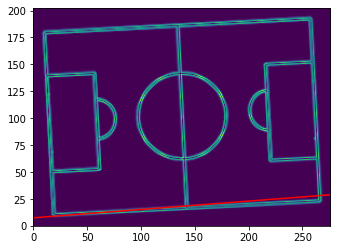

17  de  1000
18  de  1000
19  de  1000
20  de  1000
21  de  1000
22  de  1000
23  de  1000
24  de  1000
25  de  1000
26  de  1000
27  de  1000
28  de  1000
29  de  1000
30  de  1000
31  de  1000
32  de  1000
33  de  1000
34  de  1000
35  de  1000
36  de  1000
37  de  1000
38  de  1000
39  de  1000
40  de  1000
41  de  1000
42  de  1000
43  de  1000
44  de  1000
45  de  1000
46  de  1000
47  de  1000
48  de  1000
49  de  1000
50  de  1000
51  de  1000
52  de  1000
53  de  1000
54  de  1000
[0.0297029702970297, 180.3960396039604, 1581, (155, 185, 54, 182)]


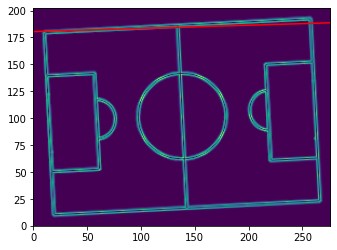

55  de  1000
56  de  1000
57  de  1000
58  de  1000
59  de  1000
60  de  1000
61  de  1000
62  de  1000
63  de  1000
64  de  1000
65  de  1000
66  de  1000
67  de  1000
68  de  1000
69  de  1000
70  de  1000
71  de  1000
72  de  1000
73  de  1000
74  de  1000
75  de  1000
76  de  1000
77  de  1000
78  de  1000
79  de  1000
80  de  1000
81  de  1000
82  de  1000
83  de  1000
84  de  1000
85  de  1000
86  de  1000
87  de  1000
88  de  1000
89  de  1000
90  de  1000
91  de  1000
92  de  1000
93  de  1000
94  de  1000
95  de  1000
96  de  1000
97  de  1000
98  de  1000
[0.03571428571428571, 183.89285714285714, 1514, (227, 192, 115, 188)]


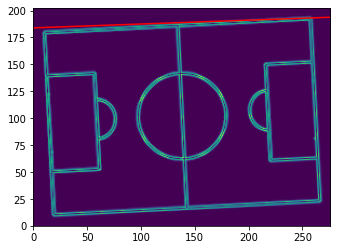

99  de  1000
100  de  1000
101  de  1000
102  de  1000
103  de  1000
104  de  1000
105  de  1000
106  de  1000
107  de  1000
108  de  1000
109  de  1000
110  de  1000
111  de  1000
112  de  1000
113  de  1000
114  de  1000
115  de  1000
116  de  1000
117  de  1000
118  de  1000
119  de  1000
120  de  1000
121  de  1000
122  de  1000
123  de  1000
124  de  1000
125  de  1000
126  de  1000
127  de  1000
128  de  1000
129  de  1000
130  de  1000
131  de  1000
132  de  1000
133  de  1000
134  de  1000
135  de  1000
136  de  1000
137  de  1000
138  de  1000
139  de  1000
140  de  1000
141  de  1000
142  de  1000
143  de  1000
144  de  1000
145  de  1000
146  de  1000
147  de  1000
148  de  1000
149  de  1000
150  de  1000
151  de  1000
152  de  1000
153  de  1000
154  de  1000
155  de  1000
156  de  1000
157  de  1000
158  de  1000
159  de  1000
160  de  1000
[0.04054054054054054, 11.027027027027026, 1931, (246, 21, 24, 12)]


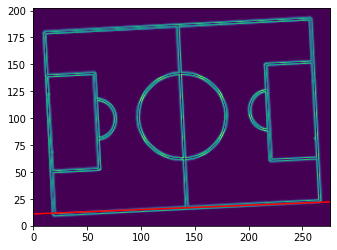

161  de  1000
162  de  1000
163  de  1000
164  de  1000
165  de  1000
166  de  1000
167  de  1000
168  de  1000
169  de  1000
170  de  1000
171  de  1000
172  de  1000
173  de  1000
174  de  1000
175  de  1000
176  de  1000
177  de  1000
178  de  1000
179  de  1000
180  de  1000
181  de  1000
182  de  1000
183  de  1000
184  de  1000
185  de  1000
186  de  1000
187  de  1000
188  de  1000
189  de  1000
190  de  1000
191  de  1000
192  de  1000
193  de  1000
194  de  1000
195  de  1000
196  de  1000
197  de  1000
198  de  1000
199  de  1000
200  de  1000
201  de  1000
202  de  1000
203  de  1000
204  de  1000
205  de  1000
206  de  1000
207  de  1000
208  de  1000
209  de  1000
210  de  1000
211  de  1000
212  de  1000
213  de  1000
214  de  1000
215  de  1000
216  de  1000
217  de  1000
218  de  1000
219  de  1000
220  de  1000
221  de  1000
222  de  1000
223  de  1000
224  de  1000
225  de  1000
226  de  1000
227  de  1000
228  de  1000
229  de  1000
230  de  1000
231  de  1000
232  d

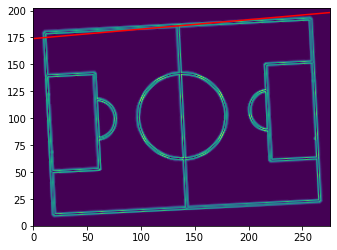

242  de  1000
243  de  1000
[0.06285714285714286, 6.3028571428571425, 1731, (27, 8, 202, 19)]


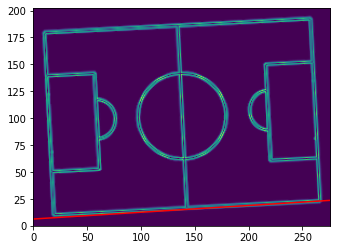

244  de  1000
245  de  1000
246  de  1000
247  de  1000
248  de  1000
249  de  1000
[0.051470588235294115, 177.21323529411765, 1642, (229, 189, 93, 182)]


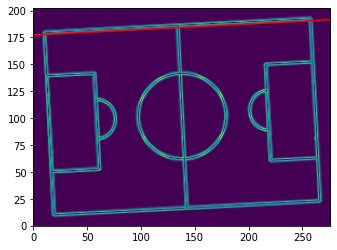

250  de  1000
251  de  1000
252  de  1000
253  de  1000
254  de  1000
255  de  1000
256  de  1000
257  de  1000
[0.03184713375796178, 180.94267515923568, 1681, (253, 189, 96, 184)]


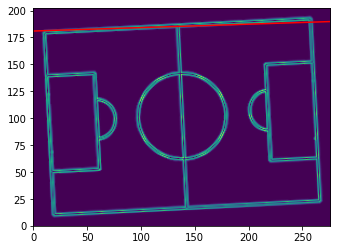

258  de  1000
259  de  1000
260  de  1000
261  de  1000
262  de  1000
263  de  1000
264  de  1000
265  de  1000
266  de  1000
267  de  1000
268  de  1000
269  de  1000
270  de  1000
271  de  1000
272  de  1000
273  de  1000
274  de  1000
275  de  1000
276  de  1000
277  de  1000
278  de  1000
279  de  1000
280  de  1000
281  de  1000
[0.09090909090909091, 3.3636363636363638, 1611, (95, 12, 260, 27)]


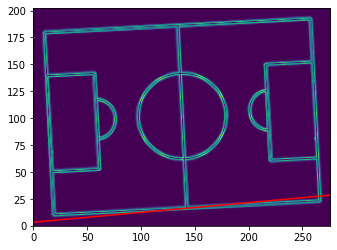

282  de  1000
283  de  1000
284  de  1000
285  de  1000
286  de  1000
287  de  1000
288  de  1000
289  de  1000
290  de  1000
291  de  1000
292  de  1000
293  de  1000
294  de  1000
295  de  1000
296  de  1000
297  de  1000
298  de  1000
299  de  1000
300  de  1000
301  de  1000
302  de  1000
303  de  1000
304  de  1000
305  de  1000
[0.0196078431372549, 14.686274509803921, 1712, (118, 17, 220, 19)]


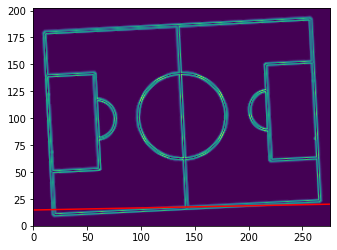

306  de  1000
307  de  1000
308  de  1000
[0.061452513966480445, 177.75977653631284, 1786, (69, 182, 248, 193)]


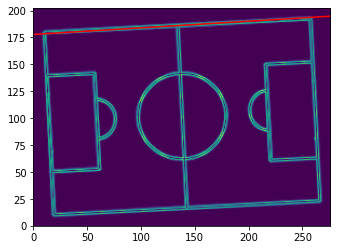

309  de  1000
310  de  1000
311  de  1000
312  de  1000
313  de  1000
314  de  1000
315  de  1000
316  de  1000
317  de  1000
318  de  1000
319  de  1000
320  de  1000
321  de  1000
322  de  1000
323  de  1000
324  de  1000
325  de  1000
326  de  1000
327  de  1000
328  de  1000
329  de  1000
330  de  1000
331  de  1000
332  de  1000
333  de  1000
334  de  1000
335  de  1000
[0.04065040650406504, 180.47154471544715, 1790, (259, 191, 13, 181)]


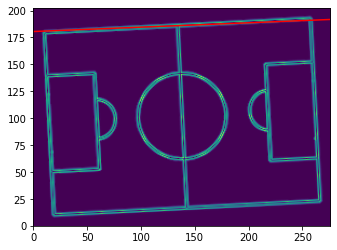

336  de  1000
337  de  1000
338  de  1000
339  de  1000
340  de  1000
341  de  1000
342  de  1000
343  de  1000
344  de  1000
345  de  1000
346  de  1000
347  de  1000
348  de  1000
349  de  1000
350  de  1000
351  de  1000
352  de  1000
353  de  1000
354  de  1000
355  de  1000
356  de  1000
357  de  1000
358  de  1000
359  de  1000
360  de  1000
361  de  1000
362  de  1000
363  de  1000
364  de  1000
365  de  1000
366  de  1000
367  de  1000
368  de  1000
369  de  1000
370  de  1000
371  de  1000
372  de  1000
373  de  1000
374  de  1000
375  de  1000
376  de  1000
377  de  1000
378  de  1000
379  de  1000
380  de  1000
381  de  1000
382  de  1000
383  de  1000
384  de  1000
385  de  1000
386  de  1000
387  de  1000
388  de  1000
389  de  1000
390  de  1000
391  de  1000
[0.05263157894736842, 180.94736842105263, 1742, (20, 182, 96, 186)]


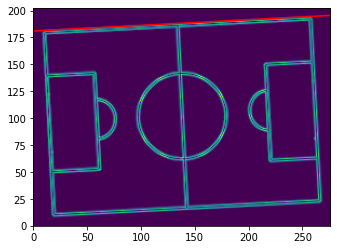

392  de  1000
393  de  1000
394  de  1000
395  de  1000
396  de  1000
397  de  1000
398  de  1000
399  de  1000
400  de  1000
401  de  1000
402  de  1000
403  de  1000
404  de  1000
405  de  1000
406  de  1000
407  de  1000
408  de  1000
409  de  1000
410  de  1000
411  de  1000
412  de  1000
413  de  1000
414  de  1000
415  de  1000
416  de  1000
417  de  1000
418  de  1000
419  de  1000
420  de  1000
421  de  1000
422  de  1000
423  de  1000
424  de  1000
425  de  1000
426  de  1000
427  de  1000
428  de  1000
429  de  1000
430  de  1000
431  de  1000
432  de  1000
433  de  1000
434  de  1000
435  de  1000
436  de  1000
437  de  1000
438  de  1000
439  de  1000
440  de  1000
441  de  1000
442  de  1000
443  de  1000
444  de  1000
445  de  1000
446  de  1000
447  de  1000
448  de  1000
449  de  1000
450  de  1000
451  de  1000
452  de  1000
453  de  1000
454  de  1000
455  de  1000
[0.043478260869565216, 12.695652173913043, 1852, (168, 20, 99, 17)]


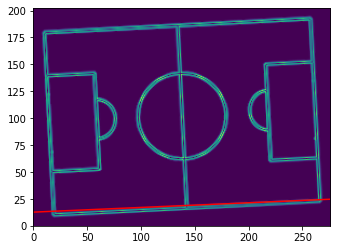

456  de  1000
457  de  1000
458  de  1000
459  de  1000
460  de  1000
461  de  1000
462  de  1000
463  de  1000
464  de  1000
465  de  1000
466  de  1000
467  de  1000
468  de  1000
469  de  1000
470  de  1000
471  de  1000
472  de  1000
473  de  1000
474  de  1000
475  de  1000
476  de  1000
477  de  1000
478  de  1000
479  de  1000
[0.06550218340611354, 178.34497816593887, 1741, (239, 194, 10, 179)]


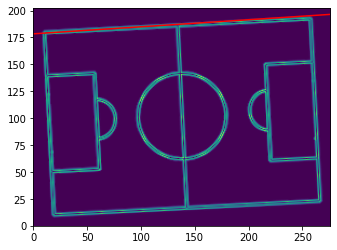

480  de  1000
481  de  1000
482  de  1000
483  de  1000
484  de  1000
485  de  1000
486  de  1000
487  de  1000
488  de  1000
489  de  1000
490  de  1000
491  de  1000
492  de  1000
493  de  1000
494  de  1000
495  de  1000
496  de  1000
497  de  1000
498  de  1000
499  de  1000
500  de  1000
501  de  1000
502  de  1000
503  de  1000
504  de  1000
505  de  1000
506  de  1000
507  de  1000
508  de  1000
509  de  1000
510  de  1000
511  de  1000
512  de  1000
513  de  1000
514  de  1000
515  de  1000
516  de  1000
517  de  1000
518  de  1000
519  de  1000
520  de  1000
521  de  1000
522  de  1000
523  de  1000
524  de  1000
525  de  1000
526  de  1000
527  de  1000
528  de  1000
529  de  1000
530  de  1000
531  de  1000
532  de  1000
533  de  1000
534  de  1000
535  de  1000
536  de  1000
537  de  1000
538  de  1000
539  de  1000
540  de  1000
541  de  1000
542  de  1000
543  de  1000
544  de  1000
545  de  1000
546  de  1000
547  de  1000
548  de  1000
549  de  1000
550  de  1000
551  d

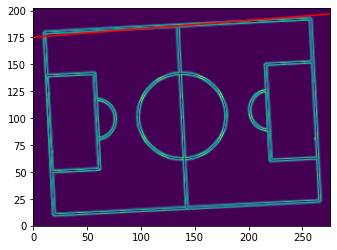

597  de  1000
598  de  1000
599  de  1000
600  de  1000
601  de  1000
602  de  1000
603  de  1000
604  de  1000
605  de  1000
606  de  1000
607  de  1000
608  de  1000
609  de  1000
610  de  1000
611  de  1000
612  de  1000
613  de  1000
614  de  1000
615  de  1000
616  de  1000
617  de  1000
618  de  1000
619  de  1000
620  de  1000
621  de  1000
622  de  1000
623  de  1000
624  de  1000
625  de  1000
626  de  1000
627  de  1000
628  de  1000
629  de  1000
630  de  1000
631  de  1000
632  de  1000
633  de  1000
634  de  1000
635  de  1000
636  de  1000
637  de  1000
638  de  1000
639  de  1000
640  de  1000
641  de  1000
642  de  1000
643  de  1000
644  de  1000
645  de  1000
646  de  1000
647  de  1000
648  de  1000
649  de  1000
650  de  1000
651  de  1000
652  de  1000
653  de  1000
654  de  1000
655  de  1000
656  de  1000
657  de  1000
658  de  1000
659  de  1000
660  de  1000
661  de  1000
662  de  1000
663  de  1000
664  de  1000
665  de  1000
[0.09090909090909091, 2.3636363636

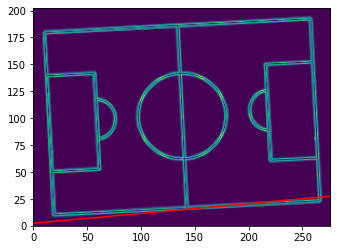

666  de  1000
667  de  1000
668  de  1000
669  de  1000
670  de  1000
671  de  1000
672  de  1000
673  de  1000
[0.06282722513089005, 8.99476439790576, 1942, (16, 10, 207, 22)]


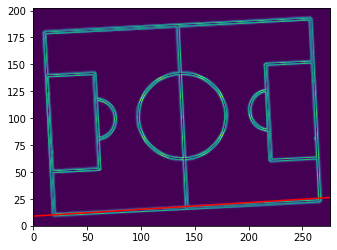

674  de  1000
675  de  1000
676  de  1000
677  de  1000
678  de  1000
679  de  1000
680  de  1000
681  de  1000
682  de  1000
683  de  1000
684  de  1000
685  de  1000
686  de  1000
687  de  1000
688  de  1000
689  de  1000
690  de  1000
691  de  1000
692  de  1000
693  de  1000
694  de  1000
695  de  1000
696  de  1000
697  de  1000
698  de  1000
699  de  1000
700  de  1000
701  de  1000
702  de  1000
[0.04, 14.48, 1578, (163, 21, 113, 19)]


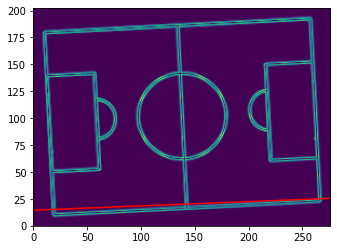

703  de  1000
704  de  1000
705  de  1000
706  de  1000
707  de  1000
708  de  1000
709  de  1000
710  de  1000
711  de  1000
712  de  1000
713  de  1000
714  de  1000
715  de  1000
716  de  1000
717  de  1000
718  de  1000
719  de  1000
720  de  1000
721  de  1000
722  de  1000
723  de  1000
724  de  1000
725  de  1000
726  de  1000
[0.030303030303030304, 12.757575757575758, 1855, (140, 17, 107, 16)]


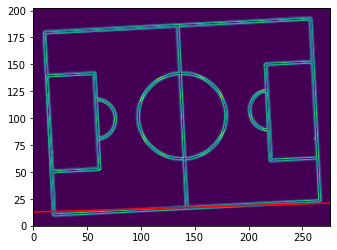

727  de  1000
728  de  1000
729  de  1000
730  de  1000
731  de  1000
732  de  1000
733  de  1000
734  de  1000
735  de  1000
736  de  1000
737  de  1000
738  de  1000
739  de  1000
740  de  1000
741  de  1000
[0.030303030303030304, 11.484848484848484, 1747, (83, 14, 248, 19)]


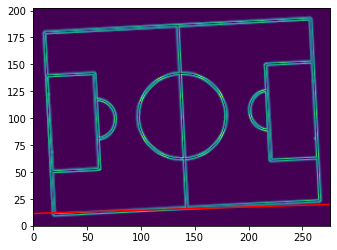

742  de  1000
743  de  1000
744  de  1000
745  de  1000
746  de  1000
747  de  1000
748  de  1000
749  de  1000
750  de  1000
751  de  1000
752  de  1000
753  de  1000
754  de  1000
755  de  1000
756  de  1000
757  de  1000
[0.03827751196172249, 179.16267942583733, 1632, (257, 189, 48, 181)]


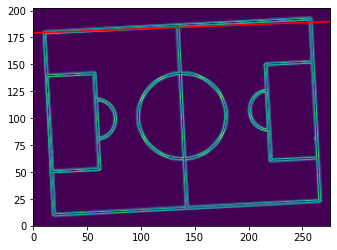

758  de  1000
759  de  1000
760  de  1000
761  de  1000
762  de  1000
763  de  1000
764  de  1000
765  de  1000
766  de  1000
767  de  1000
768  de  1000
769  de  1000
770  de  1000
771  de  1000
772  de  1000
773  de  1000
774  de  1000
775  de  1000
776  de  1000
777  de  1000
778  de  1000
779  de  1000
780  de  1000
781  de  1000
782  de  1000
783  de  1000
784  de  1000
785  de  1000
[0.0728476821192053, 6.264900662251655, 1851, (216, 22, 65, 11)]


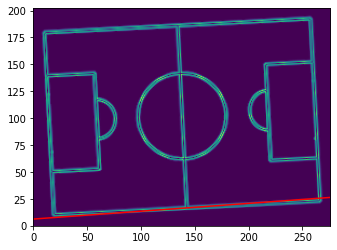

786  de  1000
787  de  1000
788  de  1000
789  de  1000
790  de  1000
791  de  1000
792  de  1000
[0.05319148936170213, 177.01063829787233, 1648, (169, 186, 75, 181)]


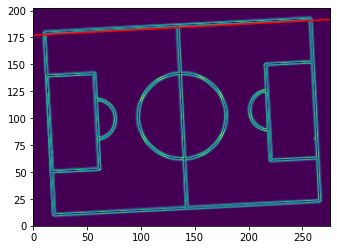

793  de  1000
794  de  1000
795  de  1000
796  de  1000
797  de  1000
798  de  1000
799  de  1000
800  de  1000
801  de  1000
802  de  1000
803  de  1000
804  de  1000
805  de  1000
806  de  1000
807  de  1000
808  de  1000
809  de  1000
810  de  1000
811  de  1000
812  de  1000
813  de  1000
814  de  1000
815  de  1000
816  de  1000
817  de  1000
818  de  1000
819  de  1000
820  de  1000
821  de  1000
822  de  1000
823  de  1000
824  de  1000
825  de  1000
826  de  1000
827  de  1000
828  de  1000
829  de  1000
830  de  1000
831  de  1000
832  de  1000
833  de  1000
834  de  1000
835  de  1000
836  de  1000
837  de  1000
838  de  1000
839  de  1000
840  de  1000
841  de  1000
[0.04225352112676056, 10.76056338028169, 1940, (266, 22, 195, 19)]


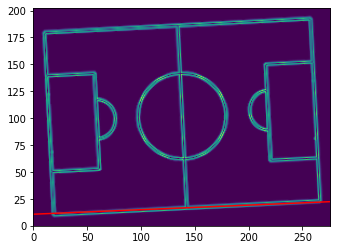

842  de  1000
843  de  1000
844  de  1000
845  de  1000
846  de  1000
847  de  1000
848  de  1000
849  de  1000
850  de  1000
851  de  1000
852  de  1000
853  de  1000
854  de  1000
855  de  1000
856  de  1000
857  de  1000
858  de  1000
859  de  1000
860  de  1000
861  de  1000
862  de  1000
863  de  1000
864  de  1000
865  de  1000
866  de  1000
867  de  1000
868  de  1000
869  de  1000
870  de  1000
871  de  1000
872  de  1000
873  de  1000
874  de  1000
875  de  1000
876  de  1000
877  de  1000
878  de  1000
879  de  1000
880  de  1000
881  de  1000
882  de  1000
883  de  1000
884  de  1000
885  de  1000
886  de  1000
887  de  1000
888  de  1000
889  de  1000
890  de  1000
891  de  1000
892  de  1000
893  de  1000
894  de  1000
895  de  1000
896  de  1000
897  de  1000
898  de  1000
[0.07692307692307693, 173.84615384615384, 1536, (145, 185, 184, 188)]


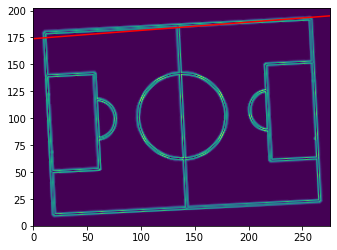

899  de  1000
900  de  1000
901  de  1000
902  de  1000
903  de  1000
904  de  1000
905  de  1000
906  de  1000
907  de  1000
908  de  1000
909  de  1000
910  de  1000
911  de  1000
912  de  1000
913  de  1000
914  de  1000
915  de  1000
916  de  1000
917  de  1000
918  de  1000
919  de  1000
920  de  1000
921  de  1000
922  de  1000
923  de  1000
924  de  1000
925  de  1000
926  de  1000
927  de  1000
928  de  1000
929  de  1000
930  de  1000
931  de  1000
932  de  1000
933  de  1000
934  de  1000
935  de  1000
936  de  1000
[0.03636363636363636, 180.83636363636364, 1753, (142, 186, 32, 182)]


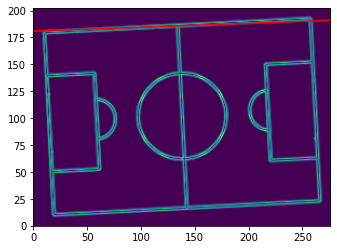

937  de  1000
938  de  1000
939  de  1000
940  de  1000
941  de  1000
942  de  1000
943  de  1000
944  de  1000
945  de  1000
946  de  1000
947  de  1000
948  de  1000
949  de  1000
950  de  1000
951  de  1000
952  de  1000
953  de  1000
954  de  1000
955  de  1000
956  de  1000
957  de  1000
958  de  1000
959  de  1000
960  de  1000
[0.016129032258064516, 183.8548387096774, 1543, (133, 186, 195, 187)]


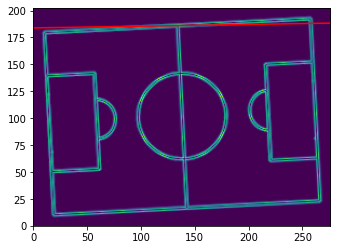

961  de  1000
962  de  1000
963  de  1000
964  de  1000
965  de  1000
966  de  1000
967  de  1000
968  de  1000
969  de  1000
970  de  1000
971  de  1000
972  de  1000
973  de  1000
974  de  1000
975  de  1000
976  de  1000
977  de  1000
978  de  1000
979  de  1000
980  de  1000
981  de  1000
982  de  1000
983  de  1000
984  de  1000
985  de  1000
986  de  1000
987  de  1000
988  de  1000
989  de  1000
990  de  1000
991  de  1000
992  de  1000
993  de  1000
994  de  1000
995  de  1000
996  de  1000
997  de  1000
998  de  1000
999  de  1000


'for line in lines:\n    print(line)\n    draw_lines(image_rgb,[[line[0],line[1]]])\n'

In [46]:
def ransac_loop(image_points, points_subset, omega):
    # Estimar los parametros de la recta que pasan por points_subset
    (x1, y1) = points_subset[0]
    (x2, y2) = points_subset[1]
    inliners = 0
    """Hallar la recta que pasa por los dos puntos (pendiente-m y termino independiente-b)"""
    if x1 == x2:
        m = 0
        b = 0
    else:
        m = (y1-y2)/(x1-x2)
        b = (x1*y2 - x2*y1)/(x1-x2)
 
     # Contar cantidad de puntos de la imagen que "pasan" por la recta
    """Medimos la distancia desde todos los puntos blancos de la imagen de intensidad a la recta 
    y donde la distancia es menor a omega los consideramos como inliners """
    for (x3, y3) in image_points:
        d = np.abs(np.linalg.norm(np.cross((x2-x1, y2-y1), (x1-x3, y1-y3)))/np.linalg.norm((x2-x1, y2-y1)))
        if d <= omega:
            inliners+=1
            #print("recta: ",(m,b),", punto: ",(x3,y3),", distancia: ",d)
   
    return [m,b, inliners, (x1,y1,x2,y2)]


def ransac(image, omega, N):
    
    # Transformar los puntos de la imágen con intensidad positiva en coordenadas
    image_points = []
    width = len(image[0])
    height = len(image)
    print('width: ', width, ', height: ', height)
    for y in range(0, height):
        for x in range(0, width):
            if image[y][x] > 0:
                image_points.append([x,height-y])
    print(len(image_points))

    # Iterar ransac_loop sobre todos los subsets de puntos
    possible_lines = [] # Array de posibles rectas, falta filtrar dependiendo de sus inliners
    # Esto es una primer aproximacion pero está mal, tendria que agarrar muestras aleatorias y parar cuando se alcanza el N o se cumple algun parametro de satisfacción
    for i in range(0, N):
        points_subset = [random.choice(image_points), random.choice(image_points)]
        line = ransac_loop(image_points, points_subset, omega)
        print(i, " de ", N)
        if line[2] > 1500 and line not in possible_lines: # Se toman en cuenta solo las rectas que tienen x o mas inliners a manera de filtro
            print(line)
            possible_lines.append(line)
            draw_lines(intensitity_image,[[line[0],line[1]]])
    # Iterar sobre las lineas detectadas y filtrar dependiendo de la cantidad de inliners detectados
    possible_lines = sorted(possible_lines, key=lambda x: x[2])
    lines = possible_lines[0:4]
    return possible_lines

lines = ransac(intensitity_image, 5, 1000)
"""for line in lines:
    print(line)
    draw_lines(image_rgb,[[line[0],line[1]]])
"""

